In [1]:
import pandas as pd

In [31]:
df = pd.read_csv('../data/quora_clean_r1.csv')

In [32]:
del df['Unnamed: 0']

In [7]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [33]:
df = df[df['Answer'].isnull() == False]

In [34]:
df['processed_text'] = df['Answer'].apply(process_text)

In [35]:
df

,Question,Answer,processed_text
0,Can I use Comet and bleach to clean my bathroom,You can use both but not at the same time. Com...,"[use, time, comet, abras, cleanser, best, use,..."
1,Which is the best full home deep cleaning serv...,Which is the best full home deep cleaning serv...,"[best, home, deep, clean, servic, compani, dubai]"
2,What is the best way to clean a tub in a hotel...,What is the best way to clean a tub in a hotel...,"[best, way, clean, tub, hotel, befor]"
3,Can you use Clorox wipes on yoga mats,In the wake of the ongoing global health crisi...,"[wake, ongo, global, health, crisi, consum, de..."
4,How do you get white stains water out of light...,"Ok, I m not a chemist, but I have done a lot o...","[ok, chemist, lot, clean, white, stain, miner,..."
...,...,...,...
774,How do I clean glasses properly at home,Glasses may be best washed with methyl alcohol...,"[glass, best, wash, methyl, alcohol, plain, wa..."
775,Is disinfectant the same as bleach,"No, although Bleach does have disinfectant pro...","[bleach, doe, disinfect, properti, doe, lot, j..."
777,Why should the toothbrush be disinfected and h...,In the wake of the ongoing global health crisi...,"[wake, ongo, global, health, crisi, consum, de..."
778,How is the YIGII paper towel holder for a bath...,How is the YIGII paper towel holder for a bath...,"[yigii, paper, towel, holder, bathroom]"


In [37]:
from collections import Counter

In [38]:
# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

In [39]:
top_20

,word,frequency
0,clean,3088
1,use,1887
2,search,1440
3,wash,1289
4,water,1036
5,custom,990
6,answer,812
7,whi,789
8,best,757
9,make,754


In [40]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

8304

In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

NameError: name 'file_path' is not defined

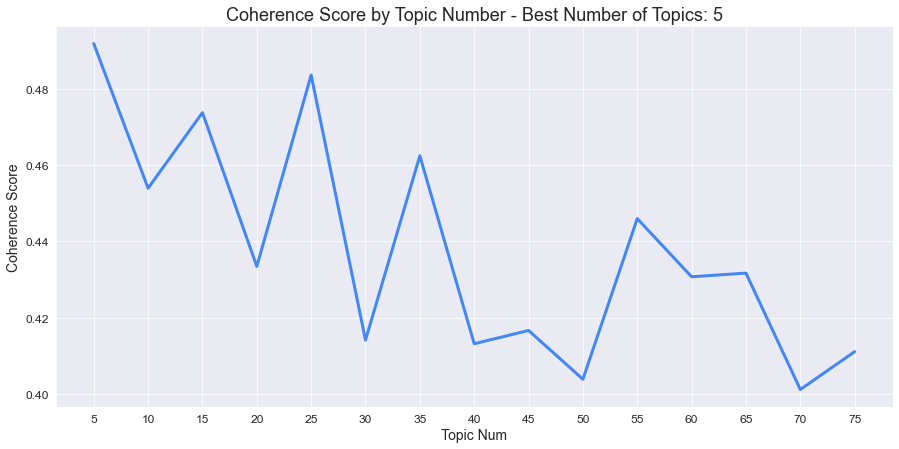

In [44]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

file_name = 'c_score'

# fig.savefig(
#     file_path + file_name + '.png',
#     dpi=fig.dpi,
#     bbox_inches='tight'
# )

plt.show()

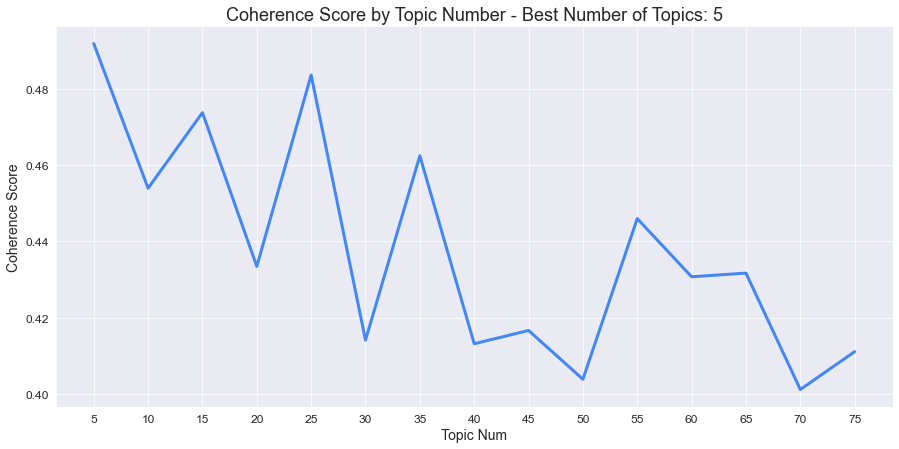

In [47]:
fig

In [48]:
# USING 25 topics for variety
# highest coherence score to run the 
# sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=25,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [49]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

,0,1,2,3,4,5,6,7,topics
0,search,custom,answer,brand,search experi,experi,deliv,websit,search custom answer brand experi deliv websit
1,clean,veget,whi,board,ammonia,pan,requir,project,clean veget whi board ammonia pan requir project
2,wash,machin,wash machin,washer,towel,portabl,whiten,load,wash machin washer towel portabl whiten load
3,car,car wash,wash,cost,wax,wax car,near,doe,car wash cost wax near doe
4,clean servic,servic,clean,best,provid,best clean,compani,commerci clean,clean servic best provid compani commerci


In [50]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

,topic_num,topics
0,0,search custom answer brand experi deliv websit
1,1,clean veget whi board ammonia pan requir project
2,2,wash machin washer towel portabl whiten load
3,3,car wash cost wax near doe
4,4,clean servic best provid compani commerci


In [51]:
topic_df

,topic_num,topics
0,0,search custom answer brand experi deliv websit
1,1,clean veget whi board ammonia pan requir project
2,2,wash machin washer towel portabl whiten load
3,3,car wash cost wax near doe
4,4,clean servic best provid compani commerci
5,5,stain remov gram melamin floor wine white
6,6,room clean mom make time bed tell
7,7,drain sewer pipe shower water acid septic sink
8,8,vacuum cleaner dust carpet review robot
9,9,dishwash dish rins water bosch microwav wash load


In [52]:
docweights.argmax(axis=1)

array([ 0,  4, 11,  0,  5, 10,  7,  8,  2,  0, 18,  1,  5, 20, 22,  1, 20,
       18,  4,  8,  4,  1,  0, 10,  1,  1, 13,  3,  4, 14,  8,  6, 15,  6,
       22, 18, 18,  4,  2, 12, 13, 14, 16, 11,  0,  2,  8,  1, 13,  1, 23,
       14, 16, 15,  7,  2,  5, 23,  1,  7, 15,  1,  1, 12, 16,  5,  0,  8,
        1, 14, 10,  1, 19,  9,  4, 11, 23,  3, 16, 16,  1, 15, 15, 24,  8,
       16,  8, 18,  4,  0, 23, 13,  9, 23, 22,  8,  4,  1,  9, 16,  9, 10,
       13,  9, 16, 16,  3,  3,  4, 15, 13,  1, 13,  6,  4, 18,  0,  1,  6,
       18, 23, 16, 24, 15, 17, 13, 23, 16,  1, 23,  1,  1,  4, 16, 20,  8,
       22, 20,  9,  5, 17,  6, 20, 16, 16, 16, 10, 22, 12,  6, 16, 12, 19,
       17, 10,  1, 14, 15, 23,  2,  4, 11, 13, 21, 11, 20,  2, 23,  1, 14,
       14, 21,  4, 10,  1,  5,  0,  1,  0, 12,  3, 23,  2,  8,  1, 19,  5,
       16, 19, 23,  0,  0, 20,  0, 18, 16, 24,  0, 11, 17,  9,  1,  1, 14,
       17, 20,  1,  1,  1, 17, 16,  7,  3,  2, 13,  4, 16,  0,  3, 18, 16,
        9,  5,  8, 21, 19